# Clustering analysis using appraisal theory to derive facial expressions

The purpose of this analysis is to derive facial expression from data based on psychologically meaningful annotations, and then use these facial factors to train a classifier to predict outcomes.  This analysis is inspired by Stratou et al (2017) and Hoegen et al (2023), but draw from appraisal theory of emotions to form meaningful emotions clusters.  Using appraisals to understanding facial expressions in not new, and work is done by both Ong et all (2021) or Houlihan et al (2022), Houlihan et al (2023).

In [1]:
##### Standard packages
import numpy as np
import pandas as pd
import os
import math
import random
import re

# scipy
import scipy
import scipy.spatial.distance

##### Plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

##### Clustering 
# Dynamic time warping
from dtaidistance import dtw
import dtaidistance.clustering
from tslearn import barycenters

# factor analysis
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# Decision trees and random forrests
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier

## metrics 
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score

## misc
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE # oversampling for imbalanced datasets


##### Saving 
import pickle


## Data loading and cleaning

First thing we do is that we find all relevant participant and file names

Now we load all the files

In [2]:
d_au_annotation_unfiltered = pd.read_csv("../data/d_au_annotation.csv")
d_au_annotation_unfiltered.rename(columns=lambda x: x[:-2] if x.endswith("_r") else x, inplace=True)

## Factor analysis for all participants

First we add factors from the factor analysis conducted in R

In [3]:
d_au_fairness = d_au_annotation_unfiltered.query("~(fairness != fairness)").copy() # remove na

# define the factors
f1 = ["AU06", "AU07", "AU09", "AU10"]
f1_weights = [0.854, 0.712, 0.302, 0.735]
f2 = ["AU01", "AU02"]
f2_weights = [0.986, 0.800]
f3 = ["AU15", "AU17"]
f3_weights = [0.324, 0.991]
f4 = ["AU12", "AU14"]
f4_weights = [0.776, 0.458]
f5 = ["AU25", "AU26"]
f5_weights = [0.781, 0.689]
f6 = ["AU23"]
f6_weights = [0.817]
f7 = ["AU09", "AU15"]
f7_weights = [0.304, 0.328]


# Create expressivity metrics
# # mean activation
# d_au_fairness["f1_mean"]  = d_au_fairness[f1].mean(axis=1)
# d_au_fairness["f2_mean"]  = d_au_fairness[f2].mean(axis=1)
# d_au_fairness["f3_mean"]  = d_au_fairness[f3].mean(axis=1)
# d_au_fairness["f4_mean"]  = d_au_fairness[f4].mean(axis=1)
# d_au_fairness["f5_mean"]  = d_au_fairness[f5].mean(axis=1)
# d_au_fairness["f6_mean"]  = d_au_fairness[f6].mean(axis=1)
# d_au_fairness["f7_mean"]  = d_au_fairness[f7].mean(axis=1)

# weighted mean activation
d_au_fairness["f1_mean"]  = d_au_fairness[f1].mul(f1_weights).sum(axis=1)/len(f1)
d_au_fairness["f2_mean"]  = d_au_fairness[f2].mul(f2_weights).sum(axis=1)/len(f2)
d_au_fairness["f3_mean"]  = d_au_fairness[f3].mul(f3_weights).sum(axis=1)/len(f3)
d_au_fairness["f4_mean"]  = d_au_fairness[f4].mul(f4_weights).sum(axis=1)/len(f4)
d_au_fairness["f5_mean"]  = d_au_fairness[f5].mul(f5_weights).sum(axis=1)/len(f5)
d_au_fairness["f6_mean"]  = d_au_fairness[f6].mul(f6_weights).sum(axis=1)/len(f6)
d_au_fairness["f7_mean"]  = d_au_fairness[f7].mul(f7_weights).sum(axis=1)/len(f7)

# # sum variables
# d_au_fairness["f1_sum"]  = d_au_fairness[f1].sum(axis=1)
# d_au_fairness["f2_sum"]  = d_au_fairness[f2].sum(axis=1)
# d_au_fairness["f3_sum"]  = d_au_fairness[f3].sum(axis=1)
# d_au_fairness["f4_sum"]  = d_au_fairness[f4].sum(axis=1)
# d_au_fairness["f5_sum"]  = d_au_fairness[f5].sum(axis=1)
# d_au_fairness["f6_sum"]  = d_au_fairness[f6].sum(axis=1)
# d_au_fairness["f7_sum"]  = d_au_fairness[f7].sum(axis=1)

# weighted sum variables
d_au_fairness["f1_sum"]  = d_au_fairness[f1].mul(f1_weights).sum(axis=1)
d_au_fairness["f2_sum"]  = d_au_fairness[f2].mul(f2_weights).sum(axis=1)
d_au_fairness["f3_sum"]  = d_au_fairness[f3].mul(f3_weights).sum(axis=1)
d_au_fairness["f4_sum"]  = d_au_fairness[f4].mul(f4_weights).sum(axis=1)
d_au_fairness["f5_sum"]  = d_au_fairness[f5].mul(f5_weights).sum(axis=1)
d_au_fairness["f7_sum"]  = d_au_fairness[f7].mul(f7_weights).sum(axis=1)


# # sd
# d_au_fairness["f1_sd"]  = d_au_fairness[f1].std(axis=1)
# d_au_fairness["f2_sd"]  = d_au_fairness[f2].std(axis=1)
# d_au_fairness["f3_sd"]  = d_au_fairness[f3].std(axis=1)
# d_au_fairness["f4_sd"]  = d_au_fairness[f4].std(axis=1)
# d_au_fairness["f5_sd"]  = d_au_fairness[f5].std(axis=1)
# d_au_fairness["f6_sd"]  = 0 # as it's only one AU
# d_au_fairness["f7_sd"]  = d_au_fairness[f7].std(axis=1)

# sd
d_au_fairness["f1_sd"]  = d_au_fairness[f1].mul(f1_weights).std(axis=1)
d_au_fairness["f2_sd"]  = d_au_fairness[f2].mul(f2_weights).std(axis=1)
d_au_fairness["f3_sd"]  = d_au_fairness[f3].mul(f3_weights).std(axis=1)
d_au_fairness["f4_sd"]  = d_au_fairness[f4].mul(f4_weights).std(axis=1)
d_au_fairness["f5_sd"]  = d_au_fairness[f5].mul(f5_weights).std(axis=1)
d_au_fairness["f7_sd"]  = d_au_fairness[f7].mul(f7_weights).std(axis=1)


# change variables
d_au_fairness["f1_change"]  = d_au_fairness["f1_mean"].diff().fillna(0)
d_au_fairness["f2_change"]  = d_au_fairness["f2_mean"].diff().fillna(0)
d_au_fairness["f3_change"]  = d_au_fairness["f3_mean"].diff().fillna(0)
d_au_fairness["f4_change"]  = d_au_fairness["f4_mean"].diff().fillna(0)
d_au_fairness["f5_change"]  = d_au_fairness["f5_mean"].diff().fillna(0)
d_au_fairness["f6_change"]  = d_au_fairness["f6_mean"].diff().fillna(0)
d_au_fairness["f7_change"]  = d_au_fairness["f7_mean"].diff().fillna(0)

# max
# d_au_fairness["f1_max"]  = d_au_fairness[f1].max(axis=1)
# d_au_fairness["f2_max"]  = d_au_fairness[f2].max(axis=1)
# d_au_fairness["f3_max"]  = d_au_fairness[f3].max(axis=1)
# d_au_fairness["f4_max"]  = d_au_fairness[f4].max(axis=1)
# d_au_fairness["f5_max"]  = d_au_fairness[f5].max(axis=1)
# d_au_fairness["f6_max"]  = d_au_fairness[f6].max(axis=1)
# d_au_fairness["f7_max"]  = d_au_fairness[f7].max(axis=1)
# max
d_au_fairness["f1_max"]  = d_au_fairness[f1].mul(f1_weights).max(axis=1)
d_au_fairness["f2_max"]  = d_au_fairness[f2].mul(f2_weights).max(axis=1)
d_au_fairness["f3_max"]  = d_au_fairness[f3].mul(f3_weights).max(axis=1)
d_au_fairness["f4_max"]  = d_au_fairness[f4].mul(f4_weights).max(axis=1)
d_au_fairness["f5_max"]  = d_au_fairness[f5].mul(f5_weights).max(axis=1)
d_au_fairness["f7_max"]  = d_au_fairness[f7].mul(f7_weights).max(axis=1)


d_au_fairness.fairness.value_counts()

fairness
Medium    33225
High      13356
Low       11249
Name: count, dtype: int64

# Random Forests

In [4]:
# Base model
X = d_au_fairness.copy()
y = d_au_fairness["fairness"]
average_classification = []
f1_score_list = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

    #Predict the response for test dataset
    y_pred = ["Medium"] * len(y_test)

    average_classification.append(metrics.accuracy_score(y_test, y_pred))
    
    # Calculate F1 score for each class separately

    # f1_per_class = f1_score(y_test, y_pred, average=None)
    # print(f1_per_class)

    # Calculate micro-average F1 score
    # f1_micro = f1_score(y_test, y_pred, average='micro')

    # Calculate macro-average F1 score
    # f1_macro = f1_score(y_test, y_pred, average='macro')

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))

print(np.mean(average_classification))
print(np.mean(f1_score_list))

Accuracy: 0.5725402040463428
F1: 0.4169079867159535
Accuracy: 0.5728284050953946
F1: 0.4172513423856072
Accuracy: 0.5713297596403251
F1: 0.41546682642272126
Accuracy: 0.5739235690817914
F1: 0.4185568722879512
Accuracy: 0.5832612830710704
F1: 0.42973794403641774
Accuracy: 0.5735200876131189
F1: 0.41807574429470185
Accuracy: 0.5755374949564817
F1: 0.42048305313093354
Accuracy: 0.5779007435587066
F1: 0.4233083364324816
Accuracy: 0.5811862355178973
F1: 0.4272456118931874
Accuracy: 0.5731166061444464
F1: 0.41759478344527556
0.5755144388725575
0.42046285010452306


### AU model

In [5]:
#split dataset in features and target variable
feature_cols_au = [col_name for col_name in d_au_fairness.columns if "au" in col_name.lower()]
X_au = d_au_fairness[feature_cols_au] # Features
y_au = d_au_fairness["fairness"] # Target variable


X_train_au, X_test_au, y_train_au, y_test_au = train_test_split(X_au, y_au, test_size=0.3, random_state=1) # 70% training and 30% test

In [6]:
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_au)))]}

rf = RandomForestClassifier()

grid_seach_au = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_au.fit(X_train_au, y_train_au)

print(grid_seach_au.best_params_)
print(grid_seach_au.score(X_train_au, y_train_au))
best_rf_au = grid_seach_au.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.7663101207974111


In [7]:
print(grid_seach_au.best_params_)
print(grid_seach_au.score(X_train_au, y_train_au))
best_rf_au = grid_seach_au.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}


0.7663101207974111


In [8]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_au))), random_state=1)

average_classification_au = []
f1_score_list_au = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au, y_au, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_au.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_au.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_au))
print(np.mean(f1_score_list_au))

Accuracy: 0.7285722520029972
F1: 0.6943854979363951
Accuracy: 0.7378523257824658
F1: 0.7061129411021947
Accuracy: 0.7351432359213788
F1: 0.7022237447941508
Accuracy: 0.7354890771802409
F1: 0.7035190110012697
Accuracy: 0.7297250561992046
F1: 0.6954716933767703
Accuracy: 0.7425788229869157
F1: 0.7132435364446916
Accuracy: 0.7337022306761196
F1: 0.7003744717231483
Accuracy: 0.7351432359213788
F1: 0.7036588743400924
Accuracy: 0.7357196380194824
F1: 0.7034803534271143
Accuracy: 0.7380828866217073
F1: 0.706171383682582
0.735200876131189
0.7028641507828409


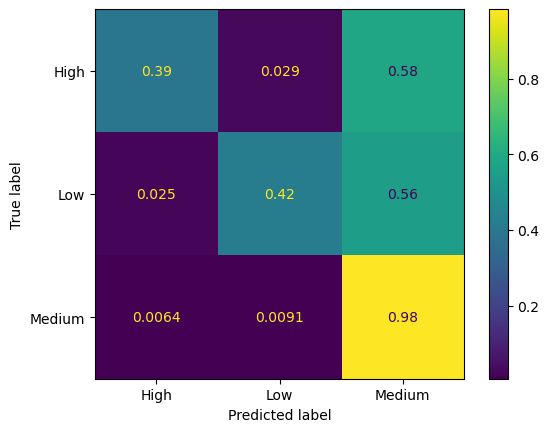

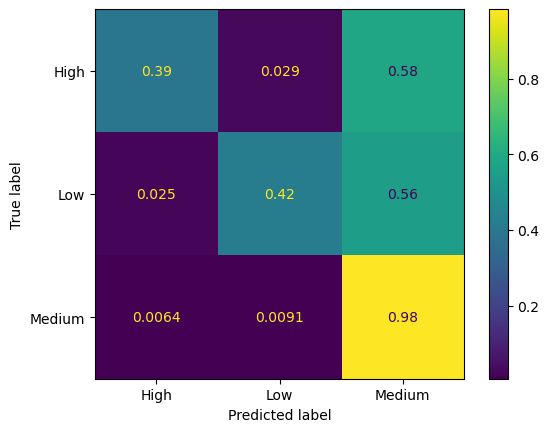

In [9]:
y_pred = best_rf_au.predict(X_test_au)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_au, y_pred, normalize="true").plot()

<Axes: >

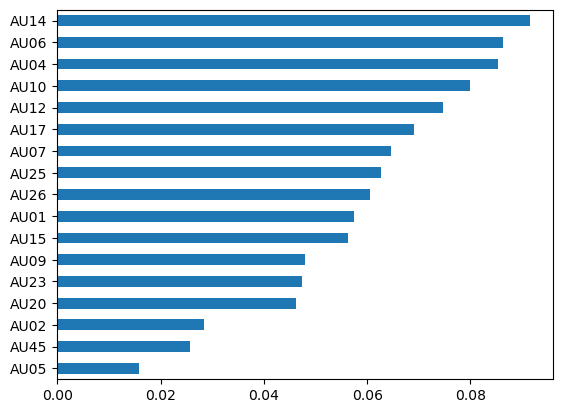

In [10]:
feature_importance_au = pd.Series(best_rf_au.feature_importances_, index=X_train_au.columns).sort_values(ascending=True)
feature_importance_au.plot.barh()

In [11]:
#split dataset in features and target variable

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f_full = re.compile(r"f\d+_(mean|sum|sd|change|max)")

# Extract matching column names
feature_cols_f_full = [col_name for col_name in d_au_fairness.columns if pattern_f_full.match(col_name)]
X_ff = d_au_fairness[feature_cols_f_full] # Features
y_ff = d_au_fairness["fairness"] # Target variable


X_train_ff, X_test_ff, y_train_ff, y_test_ff = train_test_split(X_ff, y_ff, test_size=0.3, random_state=1) # 70% training and 30% test

In [12]:
# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f_full)))]}

rf = RandomForestClassifier()

grid_seach_ff = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_ff.fit(X_train_ff, y_train_ff)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [4, 6, 8, 10],
                         'max_features': [5], 'n_estimators': [10, 30, 50]},
             scoring='accuracy')

In [13]:
print(grid_seach_ff.best_params_)
print(grid_seach_ff.score(X_train_ff, y_train_ff))
best_rf_ff = grid_seach_ff.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 30}
0.7023294879079074


In [14]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f_full))), random_state=1)

average_classification_ff = []
f1_score_list_ff = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_ff, y_ff, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_ff.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_ff.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_ff))
print(np.mean(f1_score_list_ff))

Accuracy: 0.6869560205199147
F1: 0.6369336908432811
Accuracy: 0.6784829096777912
F1: 0.6203595211470089
Accuracy: 0.6898380310104328
F1: 0.6387462031955042
Accuracy: 0.6856302956942764
F1: 0.6337742275099928
Accuracy: 0.6817684016369819
F1: 0.6268113725822669
Accuracy: 0.6791745921955156
F1: 0.6258476026291172
Accuracy: 0.6799239149230503
F1: 0.6278062526584685
Accuracy: 0.686840740100294
F1: 0.6370739320881755
Accuracy: 0.686379618421811
F1: 0.6357912249965727
Accuracy: 0.6885123061847945
F1: 0.6383150705917229
0.6843506830364862
0.6321459098242111


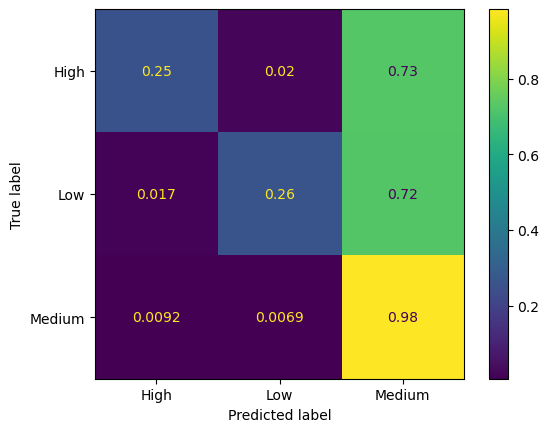

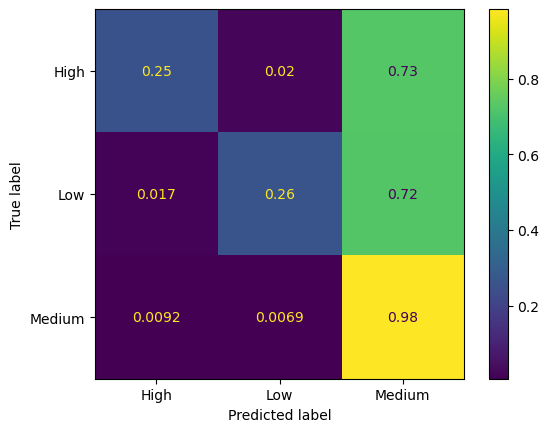

In [15]:
y_pred = best_rf_ff.predict(X_test_ff)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_ff, y_pred, normalize="true").plot()
plt.show()

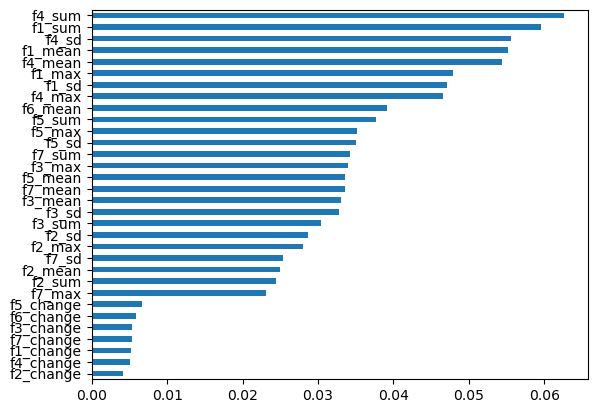

Index(['f2_change', 'f4_change', 'f1_change', 'f7_change', 'f3_change',
       'f6_change', 'f5_change', 'f7_max', 'f2_sum', 'f2_mean', 'f7_sd',
       'f2_max', 'f2_sd', 'f3_sum', 'f3_sd', 'f3_mean', 'f7_mean', 'f5_mean',
       'f3_max', 'f7_sum', 'f5_sd', 'f5_max', 'f5_sum', 'f6_mean', 'f4_max',
       'f1_sd', 'f1_max', 'f4_mean', 'f1_mean', 'f4_sd', 'f1_sum', 'f4_sum'],
      dtype='object')


In [16]:
feature_importance_ff = pd.Series(best_rf_ff.feature_importances_, index=X_train_ff.columns).sort_values(ascending=True)
feature_importance_ff.plot.barh()

plt.show()
print(feature_importance_ff.index)

In [17]:
#split dataset in features and target variable

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f = re.compile(r"f\d+_(mean|sum|sd|max)")

# Extract matching column names
feature_cols_f = [col_name for col_name in d_au_fairness.columns if pattern_f.match(col_name)]
X_f = d_au_fairness[feature_cols_f] # Features
y_f = d_au_fairness["fairness"] # Target variable


X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.3, random_state=1) # 70% training and 30% test

In [18]:
# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f)))]}

rf = RandomForestClassifier()
# #£££#wdsdljsldj 
grid_seach_f = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f.fit(X_train_f, y_train_f)
print(grid_seach_f.best_params_)
print(grid_seach_f.score(X_train_f, y_train_f))
best_rf_f = grid_seach_f.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 50}
0.7276253056989699


In [19]:
print(grid_seach_f.best_params_)
print(grid_seach_f.score(X_train_f, y_train_f))
best_rf_f = grid_seach_f.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 50}
0.7276253056989699


In [20]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f))))

average_classification_f = []
f1_score_list_f = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f))
print(np.mean(f1_score_list_f))

Accuracy: 0.6911061156262609
F1: 0.6435727457644461
Accuracy: 0.6960631736699522
F1: 0.6497077058023453
Accuracy: 0.7073606547927834
F1: 0.666953193973646
Accuracy: 0.6846504121275001
F1: 0.6347500538586685
Accuracy: 0.693181163179434
F1: 0.6465821177570164
Accuracy: 0.7087440198282322
F1: 0.666978875734421
Accuracy: 0.7027494380079543
F1: 0.6605296786499917
Accuracy: 0.6958902530405211
F1: 0.6488441408338009
Accuracy: 0.6924894806617096
F1: 0.6455152222168902
Accuracy: 0.6947374488443138
F1: 0.6475750554966903
0.6966972159778662
0.6511008790087917


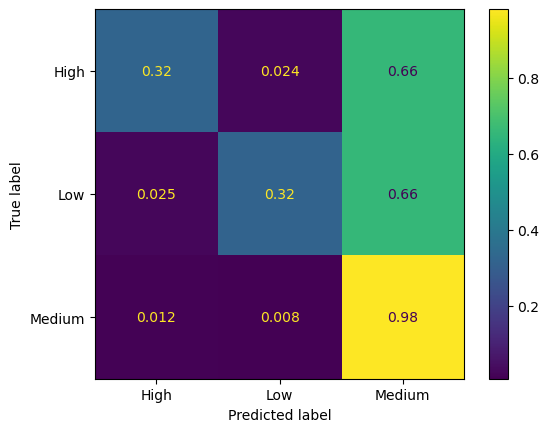

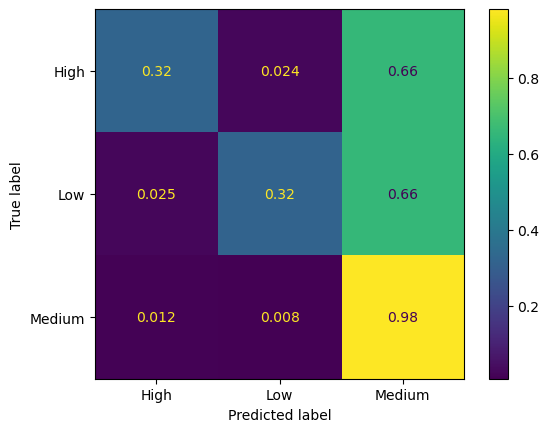

In [21]:
y_pred = best_rf_f.predict(X_test_f)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f, y_pred, normalize="true").plot()

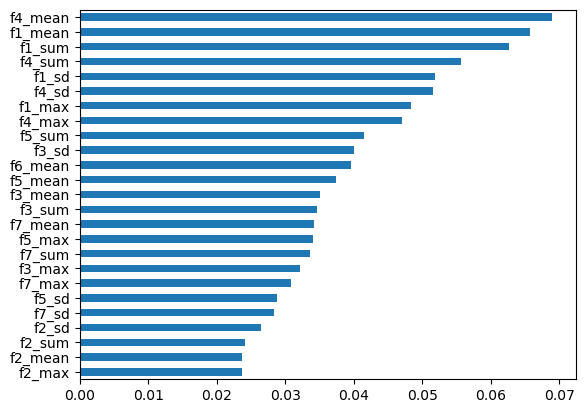

Index(['f2_max', 'f2_mean', 'f2_sum', 'f2_sd', 'f7_sd', 'f5_sd', 'f7_max',
       'f3_max', 'f7_sum', 'f5_max', 'f7_mean', 'f3_sum', 'f3_mean', 'f5_mean',
       'f6_mean', 'f3_sd', 'f5_sum', 'f4_max', 'f1_max', 'f4_sd', 'f1_sd',
       'f4_sum', 'f1_sum', 'f1_mean', 'f4_mean'],
      dtype='object')


In [22]:
feature_importance_f = pd.Series(best_rf_f.feature_importances_, index=X_train_f.columns).sort_values(ascending=True)
feature_importance_f.plot.barh()

plt.show()
print(feature_importance_f.index)

## SMOTE (oversampling)

##### AU oversampling

In [6]:
smote=SMOTE(sampling_strategy="auto")
print(y_au.value_counts())
X_au_smote, y_au_smote = smote.fit_resample(X_au, y_au)
print(y_au_smote.value_counts())



fairness
Medium    33225
High      13356
Low       11249
Name: count, dtype: int64
fairness
Medium    33225
High      33225
Low       33225
Name: count, dtype: int64


In [24]:
# Au oversampling
X_train_au_smote, X_test_au_smote, y_train_au_smote, y_test_au_smote = train_test_split(X_au_smote, y_au_smote, test_size=0.3, random_state=1) # 70% training and 30% test

In [25]:
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_au)))]}

rf = RandomForestClassifier()

grid_seach_au_smote = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_au_smote.fit(X_train_au_smote, y_train_au_smote)

print(grid_seach_au_smote.best_params_)
print(grid_seach_au_smote.score(X_train_au_smote, y_train_au_smote))
best_rf_au_smote = grid_seach_au_smote.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.8570486728200424


In [26]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_au))), random_state=1)

average_classification_au_smote = []
f1_score_list_au_smote = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au_smote, y_au_smote, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_au_smote.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_au_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_au_smote))
print(np.mean(f1_score_list_au_smote))

Accuracy: 0.831689128181119
F1: 0.8314414633892715
Accuracy: 0.8261712871618232
F1: 0.8259061802724537
Accuracy: 0.8318563354847339
F1: 0.8316219909624166
Accuracy: 0.8279102431194194
F1: 0.8276675628865008
Accuracy: 0.8295154332341237
F1: 0.8291974584146312
Accuracy: 0.8346988596461894
F1: 0.8344711011058877
Accuracy: 0.824365448282781
F1: 0.824202291154026
Accuracy: 0.8264053773868842
F1: 0.8261401024224979
Accuracy: 0.8301842624485838
F1: 0.8298464685469514
Accuracy: 0.8353342473999265
F1: 0.8350766249977968
0.8298130622345583
0.8295571244152434


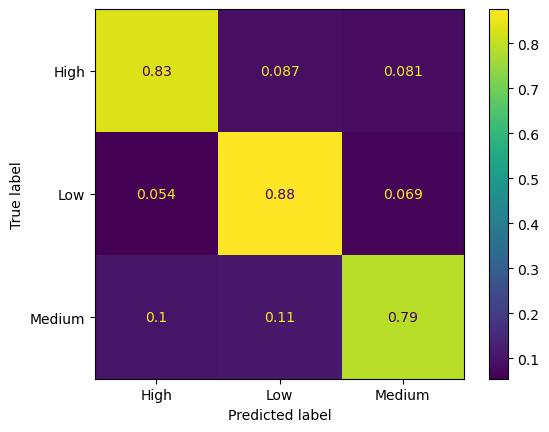

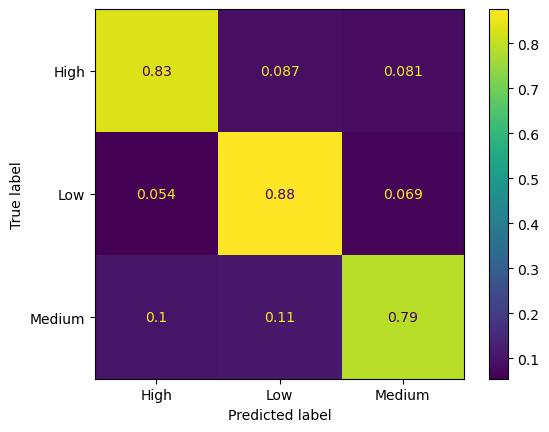

<Axes: >

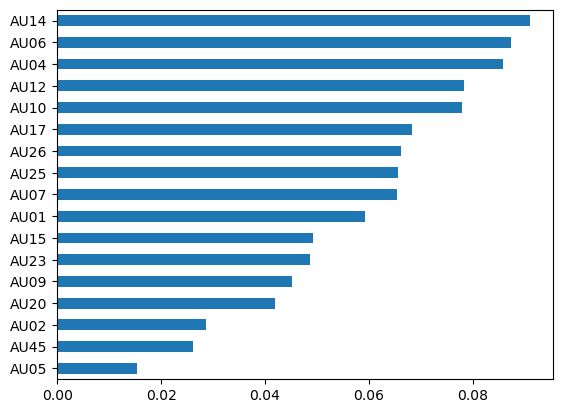

In [27]:
y_pred = best_rf_au_smote.predict(X_test_au_smote)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_au_smote, y_pred, normalize="true").plot()
plt.show()
feature_importance_au_smote = pd.Series(best_rf_au_smote.feature_importances_, index=X_train_au.columns).sort_values(ascending=True)
feature_importance_au_smote.plot.barh()

### BASE model

In [28]:
average_classification_smote = []
f1_score_list_smote = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au_smote, y_au_smote, test_size=0.3) # 70% training and 30% test

    #Predict the response for test dataset
    y_pred = ["Medium"] * len(y_test)

    average_classification_smote.append(metrics.accuracy_score(y_test, y_pred))
    
    # Calculate F1 score for each class separately

    # f1_per_class = f1_score(y_test, y_pred, average=None)
    # print(f1_per_class)

    # Calculate micro-average F1 score
    # f1_micro = f1_score(y_test, y_pred, average='micro')

    # Calculate macro-average F1 score
    # f1_macro = f1_score(y_test, y_pred, average='macro')

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))

print(np.mean(average_classification_smote))
print(np.mean(f1_score_list_smote))

Accuracy: 0.33561849981607195
F1: 0.16867058585112787
Accuracy: 0.33538440959101096
F1: 0.16846490252370275
Accuracy: 0.3340133097013678
F1: 0.16726203591272526
Accuracy: 0.3337123365548607
F1: 0.1669984156502159
Accuracy: 0.33317727318329265
F1: 0.1665301345871241
Accuracy: 0.32933150520014715
F1: 0.16317862007049128
Accuracy: 0.3366886265592081
F1: 0.1696120233268173
Accuracy: 0.3341805170049828
F1: 0.16740855757122483
Accuracy: 0.3305019563254523
F1: 0.16419599026614615
Accuracy: 0.3320068220579875
F1: 0.16550745546894127
0.33346152559943826
0.16678287212285164


### Factor subset

In [29]:
# Create the factors on the smote'd dataset
X_f_smote = X_au_smote
y_f_smote = y_au_smote.copy()

# weighted mean activation
X_f_smote["f1_mean"]  = X_f_smote[f1].mul(f1_weights).sum(axis=1)/len(f1)
X_f_smote["f2_mean"]  = X_f_smote[f2].mul(f2_weights).sum(axis=1)/len(f2)
X_f_smote["f3_mean"]  = X_f_smote[f3].mul(f3_weights).sum(axis=1)/len(f3)
X_f_smote["f4_mean"]  = X_f_smote[f4].mul(f4_weights).sum(axis=1)/len(f4)
X_f_smote["f5_mean"]  = X_f_smote[f5].mul(f5_weights).sum(axis=1)/len(f5)
X_f_smote["f6_mean"]  = X_f_smote[f6].mul(f6_weights).sum(axis=1)/len(f6)
X_f_smote["f7_mean"]  = X_f_smote[f7].mul(f7_weights).sum(axis=1)/len(f7)

# weighted sum variables
X_f_smote["f1_sum"]  = X_f_smote[f1].mul(f1_weights).sum(axis=1)
X_f_smote["f2_sum"]  = X_f_smote[f2].mul(f2_weights).sum(axis=1)
X_f_smote["f3_sum"]  = X_f_smote[f3].mul(f3_weights).sum(axis=1)
X_f_smote["f4_sum"]  = X_f_smote[f4].mul(f4_weights).sum(axis=1)
X_f_smote["f5_sum"]  = X_f_smote[f5].mul(f5_weights).sum(axis=1)
X_f_smote["f7_sum"]  = X_f_smote[f7].mul(f7_weights).sum(axis=1)


# sd
X_f_smote["f1_sd"]  = X_f_smote[f1].mul(f1_weights).std(axis=1)
X_f_smote["f2_sd"]  = X_f_smote[f2].mul(f2_weights).std(axis=1)
X_f_smote["f3_sd"]  = X_f_smote[f3].mul(f3_weights).std(axis=1)
X_f_smote["f4_sd"]  = X_f_smote[f4].mul(f4_weights).std(axis=1)
X_f_smote["f5_sd"]  = X_f_smote[f5].mul(f5_weights).std(axis=1)
X_f_smote["f7_sd"]  = X_f_smote[f7].mul(f7_weights).std(axis=1)

# max
X_f_smote["f1_max"]  = X_f_smote[f1].mul(f1_weights).max(axis=1)
X_f_smote["f2_max"]  = X_f_smote[f2].mul(f2_weights).max(axis=1)
X_f_smote["f3_max"]  = X_f_smote[f3].mul(f3_weights).max(axis=1)
X_f_smote["f4_max"]  = X_f_smote[f4].mul(f4_weights).max(axis=1)
X_f_smote["f5_max"]  = X_f_smote[f5].mul(f5_weights).max(axis=1)
X_f_smote["f7_max"]  = X_f_smote[f7].mul(f7_weights).max(axis=1)

X_f_smote = X_f_smote[feature_cols_f]

In [30]:
X_train_f_smote, X_test_f_smote, y_train_f_smote, y_test_f_smote = train_test_split(X_f_smote, y_f_smote, test_size=0.3, random_state=1) # 70% training and 30% test

# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f)))]}

rf = RandomForestClassifier()

grid_seach_f_smote = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f_smote.fit(X_train_f_smote, y_train_f_smote)

# best parameters
print(grid_seach_f_smote.best_params_)
print(grid_seach_f_smote.score(X_train_f_smote, y_train_f_smote))
best_rf_f_smote = grid_seach_f_smote.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 50}
0.7931835120105486


In [31]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f))))

average_classification_f_smote = []
f1_score_list_f_smote = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f_smote, y_f_smote, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f_smote.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f_smote))
print(np.mean(f1_score_list_f_smote))


Accuracy: 0.7612279704377487
F1: 0.7602571174644608
Accuracy: 0.7570143463866502
F1: 0.7562790493061753
Accuracy: 0.7491221616560212
F1: 0.748267571776031
Accuracy: 0.7576497341403873
F1: 0.7569536335817751
Accuracy: 0.7647393238136642
F1: 0.7639605117368716
Accuracy: 0.7568136976223121
F1: 0.756006650433267
Accuracy: 0.7611276460555797
F1: 0.7600759801085325
Accuracy: 0.7575828512189412
F1: 0.7567247811670984
Accuracy: 0.7547737685182089
F1: 0.7538213113725065
Accuracy: 0.7494900177239742
F1: 0.7484668091422665
0.7569541517573488
0.7560813416088985


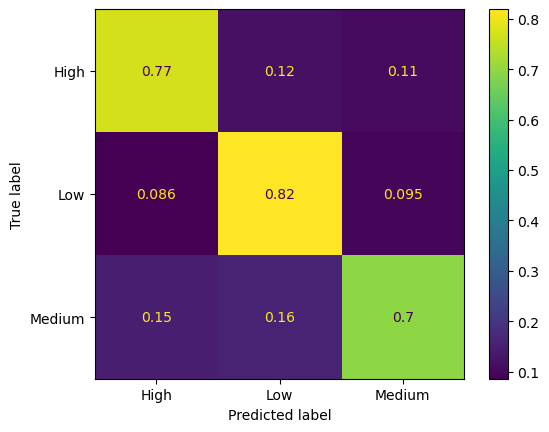

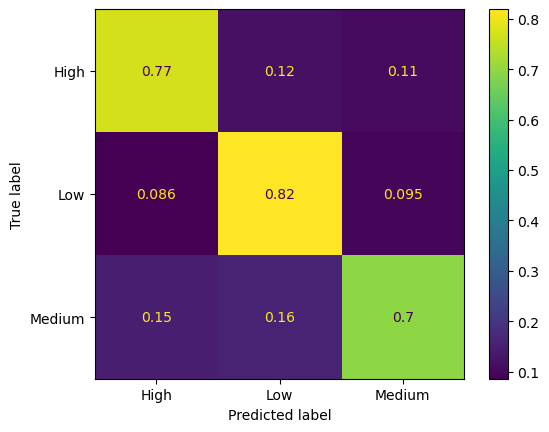

<Axes: >

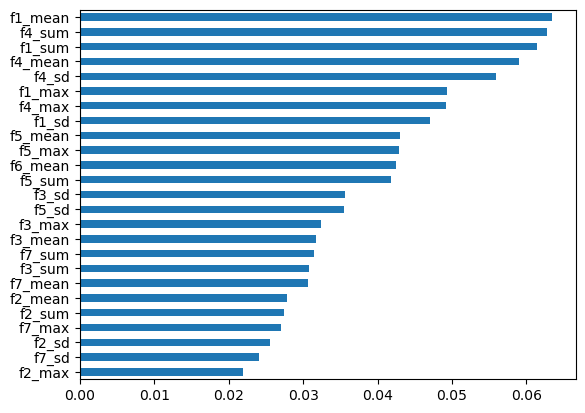

In [32]:
y_pred = best_rf_f_smote.predict(X_test_f_smote)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f_smote, y_pred, normalize="true").plot()
plt.show()
feature_importance_f_smote = pd.Series(best_rf_f_smote.feature_importances_, index=X_train_f_smote.columns).sort_values(ascending=True)
feature_importance_f_smote.plot.barh()

## Stratou

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.8086625007166198
Accuracy: 0.7701233989900679
F1: 0.7695844996999311
Accuracy: 0.7798214225997392
F1: 0.779192344999489
Accuracy: 0.7762431863023777
F1: 0.7758681265943009
Accuracy: 0.7716617061833261
F1: 0.7709222041003139
Accuracy: 0.7722636524763402
F1: 0.7716549883239787
Accuracy: 0.7717954720262181
F1: 0.7710904057870385
Accuracy: 0.7718957964083871
F1: 0.7711688829111405
Accuracy: 0.7732000133765843
F1: 0.7726371121253277
Accuracy: 0.7630672507775139
F1: 0.7625878608963126
Accuracy: 0.7746714376483965
F1: 0.7742660700969078
0.7724743336788951
0.771897249553474


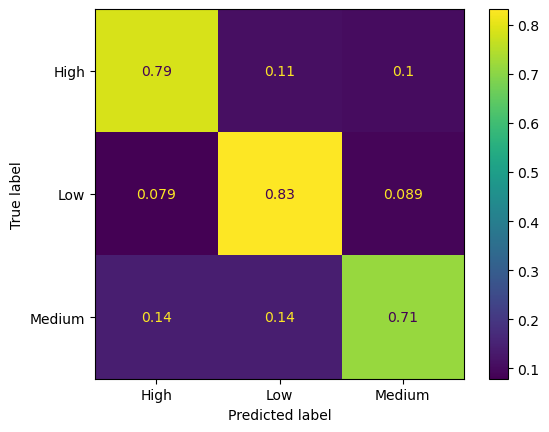

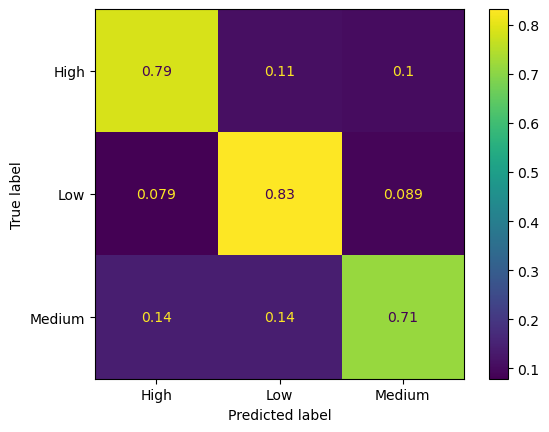

<Axes: >

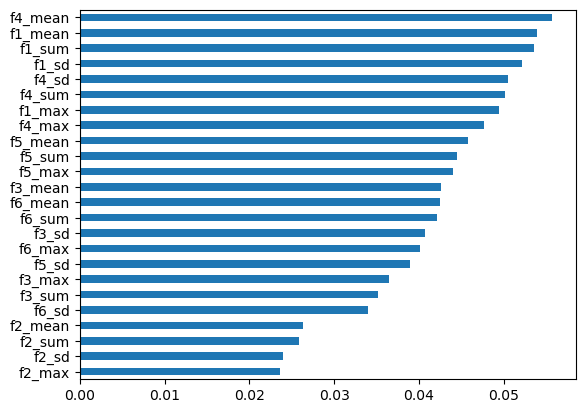

In [7]:
f1_strat = ["AU06", "AU07", "AU12"]
f1_weights_strat = [0.982, 0.446, 0.882]
f2_strat = ["AU01", "AU02"]
f2_weights_strat = [0.981, 0.873]
f3_strat = ["AU20", "AU25", "AU26"]
f3_weights_strat = [0.377, 0.951, 0.786]
f4_strat = ["AU14", "AU17", "AU23"]
f4_weights_strat = [0.724, 0.632, 0.710]
f5_strat = ["AU04", "AU07", "AU09"]
f5_weights_strat = [0.703, 0.384, 0.390]
f6_strat = ["AU10", "AU15", "AU17"]
f6_weights_strat = [0.488, 0.504, 0.420]

# Create the factors on the smote'd dataset
X_f_smote_strat = X_au_smote.copy()
y_f_smote_strat = y_au_smote.copy()

# weighted mean activation
X_f_smote_strat["f1_mean"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).sum(axis=1)/len(f1_strat)
X_f_smote_strat["f2_mean"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).sum(axis=1)/len(f2_strat)
X_f_smote_strat["f3_mean"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).sum(axis=1)/len(f3_strat)
X_f_smote_strat["f4_mean"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).sum(axis=1)/len(f4_strat)
X_f_smote_strat["f5_mean"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).sum(axis=1)/len(f5_strat)
X_f_smote_strat["f6_mean"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).sum(axis=1)/len(f6_strat)

# weighted sum variables
X_f_smote_strat["f1_sum"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).sum(axis=1)
X_f_smote_strat["f2_sum"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).sum(axis=1)
X_f_smote_strat["f3_sum"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).sum(axis=1)
X_f_smote_strat["f4_sum"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).sum(axis=1)
X_f_smote_strat["f5_sum"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).sum(axis=1)
X_f_smote_strat["f6_sum"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).sum(axis=1)


# sd
X_f_smote_strat["f1_sd"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).std(axis=1)
X_f_smote_strat["f2_sd"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).std(axis=1)
X_f_smote_strat["f3_sd"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).std(axis=1)
X_f_smote_strat["f4_sd"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).std(axis=1)
X_f_smote_strat["f5_sd"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).std(axis=1)
X_f_smote_strat["f6_sd"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).std(axis=1)

# max
X_f_smote_strat["f1_max"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).max(axis=1)
X_f_smote_strat["f2_max"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).max(axis=1)
X_f_smote_strat["f3_max"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).max(axis=1)
X_f_smote_strat["f4_max"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).max(axis=1)
X_f_smote_strat["f5_max"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).max(axis=1)
X_f_smote_strat["f6_max"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).max(axis=1)

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f_strat = re.compile(r"f\d+_(mean|sum|sd|max)")

# Extract matching column names
feature_cols_f_strat = [col_name for col_name in X_f_smote_strat.columns if pattern_f_strat.match(col_name)]

X_f_smote_strat = X_f_smote_strat[feature_cols_f_strat]

# divide 
X_train_f_smote_strat, X_test_f_smote_strat, y_train_f_smote_strat, y_test_f_smote_strat = train_test_split(X_f_smote_strat, y_f_smote_strat, test_size=0.3, random_state=1) # 70% training and 30% test

# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f_strat)))]}

rf = RandomForestClassifier()

grid_seach_f_smote_strat = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f_smote_strat.fit(X_train_f_smote_strat, y_train_f_smote_strat)

# best parameters
print(grid_seach_f_smote_strat.best_params_)
print(grid_seach_f_smote_strat.score(X_train_f_smote_strat, y_train_f_smote_strat))
best_rf_f_smote_strat = grid_seach_f_smote_strat.best_estimator_


# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f_strat))))

average_classification_f_smote_strat = []
f1_score_list_f_smote_strat = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f_smote_strat, y_f_smote_strat, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f_smote_strat.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f_smote_strat.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f_smote_strat))
print(np.mean(f1_score_list_f_smote_strat))

# plots
y_pred = best_rf_f_smote_strat.predict(X_test_f_smote_strat)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f_smote_strat, y_pred, normalize="true").plot()
plt.show()
feature_importance_f_smote_strat = pd.Series(best_rf_f_smote_strat.feature_importances_, index=X_train_f_smote_strat.columns).sort_values(ascending=True)
feature_importance_f_smote_strat.plot.barh()

In [9]:
print(list(feature_importance_f_smote_strat.index))

['f2_max', 'f2_sd', 'f2_sum', 'f2_mean', 'f6_sd', 'f3_sum', 'f3_max', 'f5_sd', 'f6_max', 'f3_sd', 'f6_sum', 'f6_mean', 'f3_mean', 'f5_max', 'f5_sum', 'f5_mean', 'f4_max', 'f1_max', 'f4_sum', 'f4_sd', 'f1_sd', 'f1_sum', 'f1_mean', 'f4_mean']
